# Hotel Price Prediction using Neural Networks

## Importing the libraries

In [288]:
import os, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

pathlib.Path('./models/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
pathlib.Path('./results/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
MODELS_DIR = pathlib.Path('./models/HotelPricePrediction/')
RESULTS_DIR = pathlib.Path('./results/HotelPricePrediction/')
DATA_DIR = pathlib.Path('./data/')

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing the data

### Splitting the targets from the data

In [289]:
train_data = pd.read_csv('./data/trainingset.csv')
train_targets = train_data['ADR']
train_data.drop(columns=['ADR'], inplace=True)

test_data = pd.read_csv('./data/testset.csv')
test_targets = test_data['ADR']
test_data.drop(columns=['ADR'], inplace=True)


In [290]:
train_data.shape, test_data.shape

((40060, 27), (79330, 27))

### Replace the missing values with the maximum number of the column

In [291]:
train_data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
DaysInWaitingList                0
CustomerType                     0
RequiredCarParkingSpaces         0
TotalOfSpecialRequests           0
ReservationStatus                0
dtype: int64

In [292]:
train_data['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: Country, Length: 125, dtype: int64

In [293]:
train_data['Country'][train_data['Country'].isna()]

30       NaN
4127     NaN
7092     NaN
7860     NaN
8779     NaN
        ... 
26473    NaN
28460    NaN
31085    NaN
31594    NaN
33087    NaN
Name: Country, Length: 464, dtype: object

In [294]:
train_data['Country'].fillna('PRT', inplace=True)

In [295]:
train_data.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64

In [296]:
test_data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
DaysInWaitingList               0
CustomerType                    0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationStatus               0
dtype: int64

In [297]:
test_data['Children'].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [298]:
test_data['Country'].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [299]:
test_data['Children'].fillna(0, inplace=True)
test_data['Country'].fillna('PRT', inplace=True)

### Encoding the categorical data on training set

In [300]:
train_data.dtypes

IsCanceled                      int64
LeadTime                        int64
ArrivalDateYear                 int64
ArrivalDateMonth               object
ArrivalDateWeekNumber           int64
ArrivalDateDayOfMonth           int64
StaysInWeekendNights            int64
StaysInWeekNights               int64
Adults                          int64
Children                        int64
Babies                          int64
Meal                           object
Country                        object
MarketSegment                  object
DistributionChannel            object
IsRepeatedGuest                 int64
PreviousCancellations           int64
PreviousBookingsNotCanceled     int64
ReservedRoomType               object
AssignedRoomType               object
BookingChanges                  int64
DepositType                    object
DaysInWaitingList               int64
CustomerType                   object
RequiredCarParkingSpaces        int64
TotalOfSpecialRequests          int64
ReservationS

In [305]:
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns


Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'CustomerType', 'ReservationStatus'],
      dtype='object')

In [275]:
encoders_list = {col: OneHotEncoder() for col in categorical_columns}

for col in categorical_columns:
    enocded_column = encoders_list[col].fit_transform(
        train_data[[col]])
    train_data = pd.concat([train_data, pd.DataFrame(
        enocded_column.toarray(),
        columns=col+'_'+encoders_list[col].categories_[0])], axis=1)
    print(encoders_list[col].categories_[0])
    train_data.drop(columns=[col], inplace=True)



['April' 'August' 'December' 'February' 'January' 'July' 'June' 'March'
 'May' 'November' 'October' 'September']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
['AGO' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BGR'
 'BHR' 'BHS' 'BIH' 'BLR' 'BRA' 'BWA' 'CAF' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR'
 'CN' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DNK'
 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI' 'FRA' 'GBR' 'GEO' 'GGY'
 'GIB' 'GRC' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KOR' 'KWT' 'LBN' 'LKA' 'LTU' 'LUX' 'LVA'
 'MAC' 'MAR' 'MDG' 'MDV' 'MEX' 'MKD' 'MLT' 'MOZ' 'MUS' 'MWI' 'MYS' 'NGA'
 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PER' 'PHL' 'PLW' 'POL' 'PRI' 'PRT'
 'QAT' 'ROU' 'RUS' 'SAU' 'SEN' 'SGP' 'SMR' 'SRB' 'SUR' 'SVK' 'SVN' 'SWE'
 'SYC' 'SYR' 'TGO' 'THA' 'TUN' 'TUR' 'TWN' 'UGA' 'UKR' 'URY' 'USA' 'UZB'
 'VEN' 'VNM' 'ZAF' 'ZMB' 'ZWE']
['Complementary' 'Corporate' 'Direct' 'Groups' 'Offline TA/TO' '

In [276]:
train_data.shape

(40060, 200)

### Replacing not encoded test samples with maximum of the column

In [25]:
for col in categorical_columns:
    encoder_cats = encoders_list[col].categories_[0]
    test_data_cats = np.sort(test_data[col].unique())
    not_known_cats = np.setdiff1d(test_data_cats, encoder_cats)
    if len(not_known_cats) != 0:
        print(f'Not known categories in test data for {col}: {not_known_cats}')
        print('Unknown categories samples in test data for {}: {}'.format(
            col, test_data[col].isin(not_known_cats).sum()))

        most_frequent_cat = test_data[col].value_counts().index[0]
        print('Replacing with most frequent category: {}'.format(
            most_frequent_cat))
        test_data[col].replace(not_known_cats, most_frequent_cat, inplace=True)
        print('Processed')
        print('--------------------------------------------')


Not known categories in test data for Country: ['ABW' 'AIA' 'ASM' 'ATA' 'ATF' 'BEN' 'BFA' 'BGD' 'BOL' 'BRB' 'DMA' 'ETH'
 'FRO' 'GAB' 'GHA' 'GLP' 'GNB' 'GTM' 'GUY' 'HND' 'IMN' 'IRQ' 'KEN' 'KHM'
 'KIR' 'KNA' 'LAO' 'LBY' 'LCA' 'LIE' 'MCO' 'MLI' 'MMR' 'MNE' 'MRT' 'MYT'
 'NAM' 'NCL' 'NIC' 'PAN' 'PRY' 'PYF' 'RWA' 'SDN' 'SLE' 'SLV' 'STP' 'TJK'
 'TMP' 'TZA' 'UMI' 'VGB']
Unknown categories samples in test data for Country: 170
Replacing with most frequent category: PRT
Processed
--------------------------------------------
Not known categories in test data for MarketSegment: ['Aviation' 'Undefined']
Unknown categories samples in test data for MarketSegment: 239
Replacing with most frequent category: Online TA
Processed
--------------------------------------------
Not known categories in test data for DistributionChannel: ['GDS']
Unknown categories samples in test data for DistributionChannel: 193
Replacing with most frequent category: TA/TO
Processed
--------------------------------------------

### Encoding the categorical data on test set

In [26]:
for col in categorical_columns:
    test_data = pd.concat([test_data, pd.DataFrame(
        encoders_list[col].transform(
        test_data[[col]]).toarray(),
        columns=col+'_'+encoders_list[col].categories_[0])], axis=1)

    test_data.drop(columns=[col], inplace=True)


In [27]:
test_data.shape

(79330, 200)

### Changing the data type of the columns

In [28]:
train_data = train_data.astype('float32')
train_targets = train_targets.astype('float32')
test_data = test_data.astype('float32')
test_targets = test_targets.astype('float32')

### Saving the pandas data

In [29]:
train_data_pd = train_data.copy()
train_targets_pd = train_targets.copy()
test_data_pd = test_data.copy()
test_targets_pd = test_targets.copy()


### Converting the data and targets into tensors

In [30]:
train_data = tf.convert_to_tensor(train_data.values,
                                        dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_targets.values,
                                     dtype=tf.float32)

test_data = tf.convert_to_tensor(test_data.values,
                                 dtype=tf.float32)
test_targets = tf.convert_to_tensor(test_targets.values,
                                    dtype=tf.float32)

2023-01-04 16:41:12.215472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 16:41:12.217047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 16:41:12.217346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 16:41:12.217562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0

In [31]:
train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

(TensorShape([40060, 200]),
 TensorShape([40060]),
 TensorShape([79330, 200]),
 TensorShape([79330]))

In [32]:
train_data.device, train_targets.device, test_data.device, test_targets.device

('/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [33]:
train_data.dtype, train_targets.dtype, test_data.dtype, test_targets.dtype

(tf.float32, tf.float32, tf.float32, tf.float32)

### Standardization of train and test data

In [34]:
mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Designing The Neural Network Model

### Multi Layer Perceptron Archtiecture

In [35]:
def get_model():
    """
    Returns a compiled model.
    """
    initializer = tf.keras.initializers.HeNormal(seed=42)
    inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(32, activation='relu',
                     kernel_initializer=initializer)(inputs)
    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model


model = get_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 32)                6432      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 128)               16512 

### Training the model with differnet number of epochs

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_selection.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=callbacks)


Epoch 1/30


KeyboardInterrupt: 

In [469]:
def plot_history(history):
    """Plot training and validation MSE loss and MAE metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title('Training and validation loss')

    epochs = range(1, len(history.history['mae']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss(MSE)')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss(MSE)')
    plt.title('Training and validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(MSE)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

    plt.show()


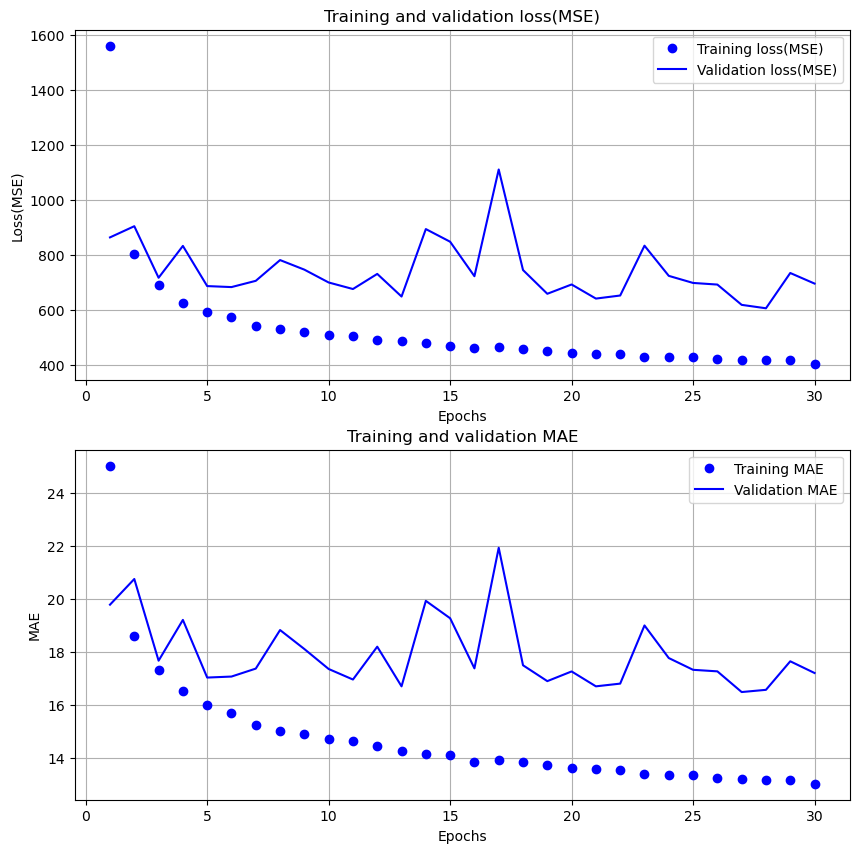

In [ ]:
plot_history(history)

Continuing the training with extra epochs

Epoch 1/50
501/501 [==============================] - 1s 2ms/step - loss: 408.4070 - mae: 13.0755 - val_loss: 637.9476 - val_mae: 16.7662
Epoch 2/50
501/501 [==============================] - 1s 2ms/step - loss: 408.4032 - mae: 13.0201 - val_loss: 640.3839 - val_mae: 16.8252
Epoch 3/50
501/501 [==============================] - 1s 2ms/step - loss: 403.2838 - mae: 12.9185 - val_loss: 617.7293 - val_mae: 16.5072
Epoch 4/50
501/501 [==============================] - 1s 2ms/step - loss: 400.2966 - mae: 12.9245 - val_loss: 618.7538 - val_mae: 16.6365
Epoch 5/50
501/501 [==============================] - 1s 3ms/step - loss: 395.3245 - mae: 12.8603 - val_loss: 686.4902 - val_mae: 17.0513
Epoch 6/50
501/501 [==============================] - 1s 2ms/step - loss: 394.3318 - mae: 12.8272 - val_loss: 708.7537 - val_mae: 17.5049
Epoch 7/50
501/501 [==============================] - 1s 2ms/step - loss: 396.2148 - mae: 12.8591 - val_loss: 630.6614 - val_mae: 16.5885
Epoch 8/50
501/501 [==============

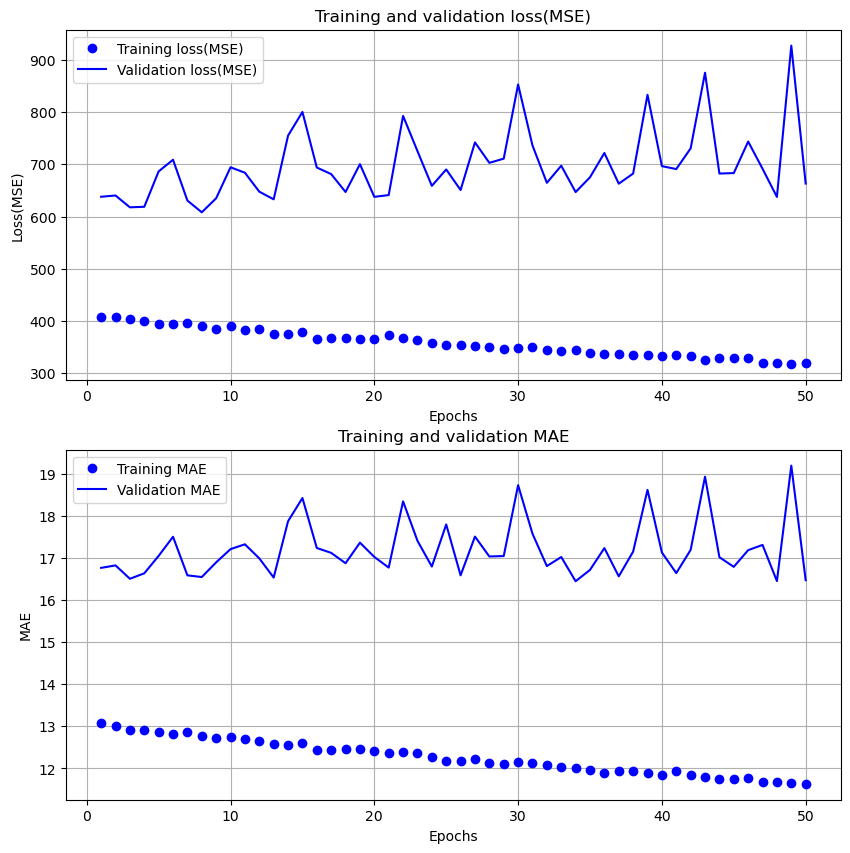

In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2 ,epochs=50,
                    batch_size=64, callbacks=callbacks)
plot_history(history)


Epoch 1/100
501/501 [==============================] - 2s 3ms/step - loss: 411.8571 - mae: 13.1430 - val_loss: 635.3090 - val_mae: 16.7151
Epoch 2/100
501/501 [==============================] - 1s 2ms/step - loss: 407.6032 - mae: 13.0136 - val_loss: 689.9136 - val_mae: 17.5472
Epoch 3/100
501/501 [==============================] - 1s 2ms/step - loss: 408.7766 - mae: 13.0617 - val_loss: 872.7690 - val_mae: 19.5078
Epoch 4/100
501/501 [==============================] - 1s 2ms/step - loss: 405.4786 - mae: 12.9755 - val_loss: 843.1556 - val_mae: 19.3513
Epoch 5/100
501/501 [==============================] - 1s 3ms/step - loss: 400.9942 - mae: 12.9744 - val_loss: 690.2314 - val_mae: 17.3698
Epoch 6/100
501/501 [==============================] - 1s 2ms/step - loss: 400.7057 - mae: 12.9115 - val_loss: 754.3329 - val_mae: 18.0983
Epoch 7/100
501/501 [==============================] - 1s 2ms/step - loss: 393.0840 - mae: 12.8298 - val_loss: 641.0866 - val_mae: 16.7406
Epoch 8/100
501/501 [======

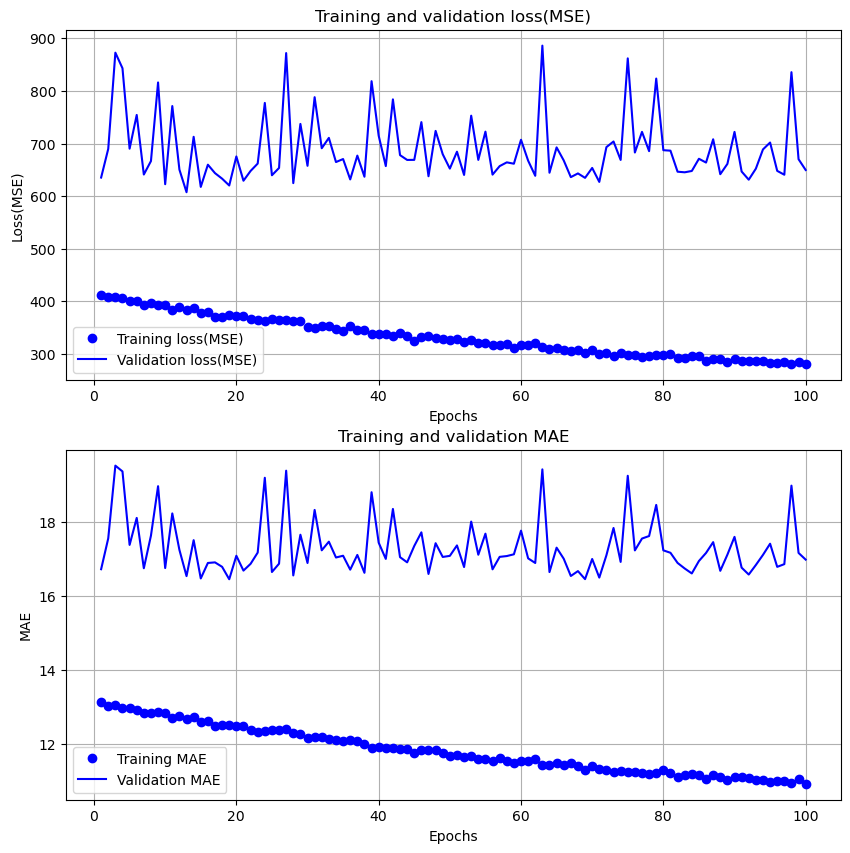

In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2,
                    epochs=100, batch_size=64, callbacks=callbacks)

plot_history(history)


## Evaluating the model on test data

In [ ]:
model = keras.models.load_model(os.path.join(
    MODELS_DIR, 'MLP_arch_with_feature_selection.keras'))

test_predictions = model.predict(test_data)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2480/2480 [==============================] - 2s 770us/step - loss: 3561.7839 - mae: 48.5235


### Saving the results

In [ ]:
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})

results_df.head(10)


,Actual,Predicted,Error
0,0.00,71.206146,-71.206146
1,76.50,87.560463,-11.060463
2,68.00,78.421066,-10.421066
3,76.50,86.858955,-10.358955
4,76.50,91.315025,-14.815025
5,76.50,88.321953,-11.821953
6,58.67,81.688972,-23.018972
7,68.00,76.647942,-8.647942
8,76.50,79.682457,-3.182457
9,76.50,79.682457,-3.182457


In [ ]:
results_df.to_csv(os.path.join(RESULTS_DIR, 'Results.csv'), index=False)


## Feature Selection Using Random Forest

In [ ]:
rnd_frst_clf = RandomForestRegressor(random_state=42)
rnd_frst_clf.fit(train_data_pd, train_targets_pd)

RandomForestRegressor(random_state=42)

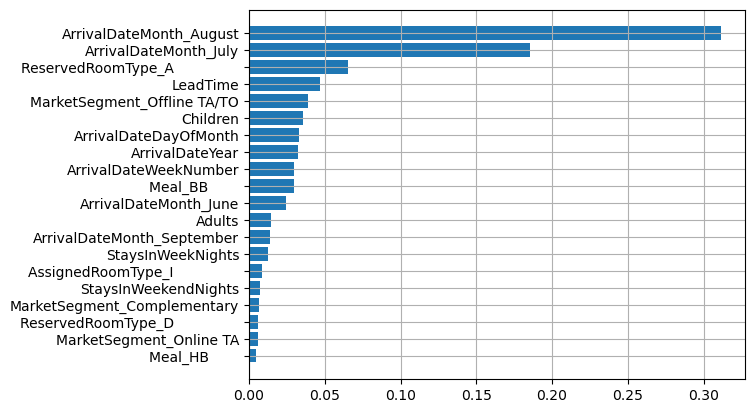

In [ ]:
f_i = list(zip(train_data_pd.columns, rnd_frst_clf.feature_importances_))
f_i.sort(key=lambda x: x[1])
plt.barh([x[0] for x in f_i[-20:]], [x[1] for x in f_i[-20:]])
plt.grid()
plt.show()

In [ ]:
test_data_pd.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies',
       ...
       'DepositType_No Deposit     ', 'DepositType_Non Refund     ',
       'DepositType_Refundable     ', 'CustomerType_Contract',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ReservationStatus_Canceled',
       'ReservationStatus_Check-Out', 'ReservationStatus_No-Show'],
      dtype='object', length=200)

In [ ]:
selected_features = [x[0] for x in f_i if x[1] > 0.005]

train_data = tf.convert_to_tensor(train_data_pd[selected_features].values,
                                  dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data_pd[selected_features].values,
                                 dtype=tf.float32)

mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std


In [ ]:
selected_features

['MarketSegment_Online TA',
 'ReservedRoomType_D               ',
 'MarketSegment_Complementary',
 'StaysInWeekendNights',
 'AssignedRoomType_I               ',
 'StaysInWeekNights',
 'ArrivalDateMonth_September',
 'Adults',
 'ArrivalDateMonth_June',
 'Meal_BB       ',
 'ArrivalDateWeekNumber',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'Children',
 'MarketSegment_Offline TA/TO',
 'LeadTime',
 'ReservedRoomType_A               ',
 'ArrivalDateMonth_July',
 'ArrivalDateMonth_August']

In [ ]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_selection.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=callbacks)
plot_history(history)


Epoch 1/30
501/501 [==============================] - 5s 7ms/step - loss: 1512.7059 - mae: 25.9024 - val_loss: 1359.0822 - val_mae: 26.3545
Epoch 2/30
501/501 [==============================] - 3s 6ms/step - loss: 890.0370 - mae: 20.2511 - val_loss: 1030.7139 - val_mae: 22.4027
Epoch 3/30
501/501 [==============================] - 3s 6ms/step - loss: 776.3538 - mae: 18.7861 - val_loss: 950.5502 - val_mae: 21.4835
Epoch 4/30
501/501 [==============================] - 3s 6ms/step - loss: 723.5492 - mae: 17.9469 - val_loss: 958.3123 - val_mae: 21.1119
Epoch 5/30
501/501 [==============================] - 3s 6ms/step - loss: 672.9533 - mae: 17.2187 - val_loss: 1439.8478 - val_mae: 26.7492
Epoch 6/30
501/501 [==============================] - 3s 6ms/step - loss: 639.8842 - mae: 16.7594 - val_loss: 877.2829 - val_mae: 20.4120
Epoch 7/30
501/501 [==============================] - 3s 5ms/step - loss: 629.9205 - mae: 16.4490 - val_loss: 833.9539 - val_mae: 19.6181
Epoch 8/30
501/501 [==========

In [ ]:
model.evaluate(test_data, test_targets)

2480/2480 [==============================] - 7s 3ms/step - loss: 2609.5813 - mae: 39.4097


[2609.581298828125, 39.409725189208984]

In [ ]:
test_predictions = model.predict(test_data)
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})
results_df.to_csv(os.path.join(RESULTS_DIR, 'SelectedResults.csv'),
                  index=False)


2480/2480 [==============================] - 4s 2ms/step


## Importing the original data and working with it

In [452]:
data = pd.read_csv(os.path.join(DATA_DIR, 'hotel_bookings.csv'))
data.head()
data.isna().sum()


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [453]:
data.drop(['company', 'agent', ], axis=1, inplace=True)
data.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car

In [454]:
data.dropna(inplace=True)

Shuffling the data

In [455]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [456]:
(data['adr'] == 0.0).sum()


1938

Deleting zero target values

In [457]:
data.drop(data[data['adr'] == 0.0].index, inplace=True)

In [458]:
targets = data['adr']
data.drop(['adr'], axis=1, inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns)
data.shape

(116960, 1179)

In [459]:
categorical_columns

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')

In [460]:
data = data.astype('float32')
targets = targets.astype('float32')


In [461]:
train_data = data[:int(0.7 * data.shape[0])]
train_targets = targets[:int(0.7 * data.shape[0])]
test_data = data[int(0.7 * data.shape[0]):]
test_targets = targets[int(0.7 * data.shape[0]):]

Selecting the features using random forest

In [462]:
rnd_frst_clf = RandomForestRegressor(random_state=42,
                                     n_estimators=1000,
                                     max_features=1,
                                     max_depth=100,
                                     n_jobs=-1)

rnd_frst_clf.fit(train_data, train_targets)

RandomForestRegressor(max_depth=100, max_features=1, n_estimators=1000,
                      n_jobs=-1, random_state=42)

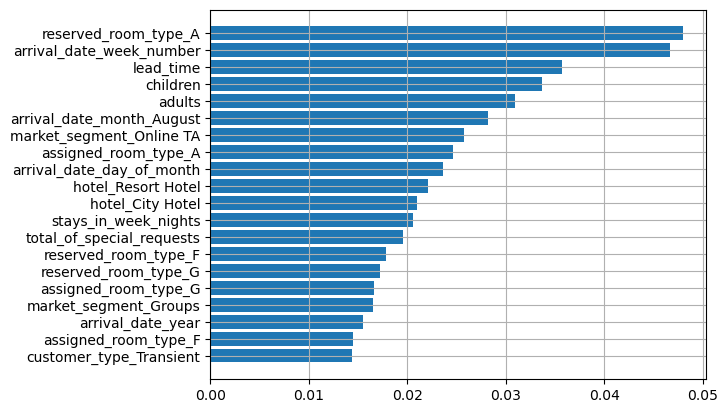

In [463]:
f_i = list(zip(train_data.columns, rnd_frst_clf.feature_importances_))
f_i.sort(key=lambda x: x[1])
plt.barh([x[0] for x in f_i[-20:]], [x[1] for x in f_i[-20:]])
plt.grid()
plt.show()

In [ ]:
selected_features = [x[0] for x in f_i if x[1] > 0.01]

scalar = StandardScaler()
train_data = scalar.fit_transform(train_data[selected_features])
test_data = scalar.transform(test_data[selected_features])


In [472]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_targets, dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_targets = tf.convert_to_tensor(test_targets, dtype=tf.float32)

In [465]:
selected_features

['arrival_date_month_February',
 'meal_BB',
 'country_PRT',
 'customer_type_Transient-Party',
 'reserved_room_type_D',
 'stays_in_weekend_nights',
 'meal_HB',
 'arrival_date_month_July',
 'market_segment_Offline TA/TO',
 'customer_type_Transient',
 'assigned_room_type_F',
 'arrival_date_year',
 'market_segment_Groups',
 'assigned_room_type_G',
 'reserved_room_type_G',
 'reserved_room_type_F',
 'total_of_special_requests',
 'stays_in_week_nights',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'arrival_date_day_of_month',
 'assigned_room_type_A',
 'market_segment_Online TA',
 'arrival_date_month_August',
 'adults',
 'children',
 'lead_time',
 'arrival_date_week_number',
 'reserved_room_type_A']

In [466]:
def get_model():
    """
    Returns a compiled model.
    """
    initializer = tf.keras.initializers.HeNormal(seed=42)
    inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(32, activation='relu',
                     kernel_initializer=initializer)(inputs)
    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation='relu',
                     kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    # Impacting the is_canceled feature
    # index = selected_features.index('is_canceled')
    # outputs *= (1-tf.math.round(inputs[:, index:index+1]))

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model


In [467]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path
        .join(MODELS_DIR,
                              'MLP_arch_with_feature_selection.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=80,
                    batch_size=64, callbacks=callbacks)


Epoch 1/30
1024/1024 [==============================] - 10s 7ms/step - loss: 1440.5394 - mae: 27.5661 - val_loss: 1668.4521 - val_mae: 32.1950
Epoch 2/30
1024/1024 [==============================] - 7s 7ms/step - loss: 832.0313 - mae: 20.9406 - val_loss: 749.0065 - val_mae: 19.5784
Epoch 3/30
1024/1024 [==============================] - 7s 7ms/step - loss: 688.2361 - mae: 18.7645 - val_loss: 865.6777 - val_mae: 21.5844
Epoch 4/30
1024/1024 [==============================] - 7s 7ms/step - loss: 611.0739 - mae: 17.4733 - val_loss: 580.1328 - val_mae: 16.9880
Epoch 5/30
1024/1024 [==============================] - 7s 7ms/step - loss: 556.9632 - mae: 16.5308 - val_loss: 509.3977 - val_mae: 15.4700
Epoch 6/30
1024/1024 [==============================] - 7s 7ms/step - loss: 520.9009 - mae: 15.8888 - val_loss: 493.8101 - val_mae: 15.2778
Epoch 7/30
1024/1024 [==============================] - 7s 7ms/step - loss: 496.1837 - mae: 15.4274 - val_loss: 412.1906 - val_mae: 14.0483
Epoch 8/30
1024/1

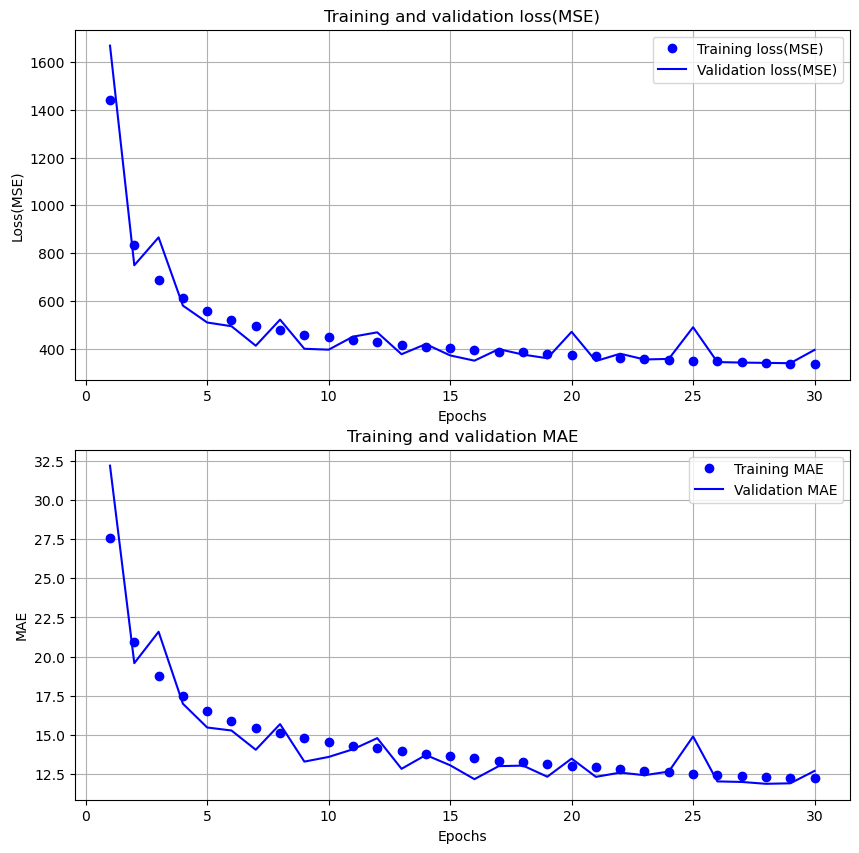

1097/1097 [==============================] - 2s 2ms/step


In [475]:
plot_history(history)

test_predictions = model.predict(test_data)
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})
results_df.to_csv(os.path.join(RESULTS_DIR, 'SelectedFeaturesResults_OriginalData.csv'),
                  index=False)


In [474]:
model.evaluate(test_data, test_targets)

1097/1097 [==============================] - 7s 6ms/step - loss: 1208.9124 - mae: 12.7695


[1208.912353515625, 12.769547462463379]